In [1]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import seaborn as sns
import time
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from IPython import display
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline as backend_inline

backend_inline.set_matplotlib_formats("svg")


#### Pytorch device specific configuration ###
# # Pytorch Gpu Configuration for Cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Pytorch Gpu Configuration for directml(AMD GPU)
# import torch_directml

# device = torch_directml.device()

# Set default device
torch.set_default_device(device)

# # Font update global for all plots
# plt.rcParams.update({"font.size": 18})

In [2]:
# create a class for the model
class thenet(nn.Module):
    def __init__(self):
        super().__init__()

        ### input layer
        self.input = nn.Linear(100, 100)

        ### hidden layer
        self.fc1 = nn.Linear(100, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 100)

        ### output layer
        self.output = nn.Linear(100, 2)

    # forward pass
    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.output(x)

In [3]:
# create an instance of the model
net = thenet()
print(net)

thenet(
  (input): Linear(in_features=100, out_features=100, bias=True)
  (fc1): Linear(in_features=100, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=100, bias=True)
  (output): Linear(in_features=100, out_features=2, bias=True)
)


There are 402 bias parameters.
There are 40200 weight parameters.


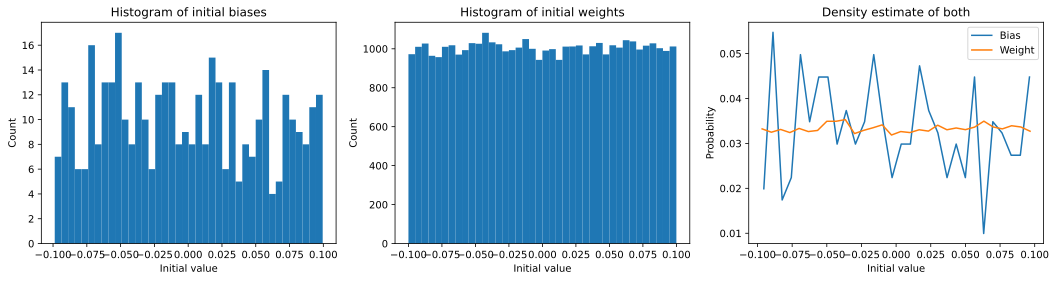

In [ ]:
# Collect all the weights and biases
allweight = np.array([])
allbiases = np.array([])

for p in net.named_parameters():
    if "bias" in p[0]:
        allbiases = np.concatenate(
            (allbiases, p[1].data.cpu().numpy().flatten()), axis=0
        )
    elif "weight" in p[0]:
        allweight = np.concatenate(
            (allweight, p[1].data.cpu().numpy().flatten()), axis=0
        )
# how many are there?
print(f"There are {len(allbiases)} bias parameters.")
print(f"There are {len(allweight)} weight parameters.")

# Show their histogram
fig, ax = plt.subplots(1, 3, figsize=(18, 4))

ax[0].hist(allbiases, 40)
ax[0].set_title("Histogram of initial biases")

ax[1].hist(allweight, 40)
ax[1].set_title("Histogram of initial weights")

# Collect histogram data to show as line plots
yB, xB = np.histogram(allbiases, 30)
yW, xW = np.histogram(allweight, 30)

ax[2].plot((xB[1:] + xB[:-1]) / 2, yB / np.sum(yB), label="Bias")
ax[2].plot((xW[1:] + xW[:-1]) / 2, yW / np.sum(yW), label="Weight")
ax[2].set_title("Density estimate of both")
ax[2].legend()

# plot adjustments common to all subplots
for i in range(3):
    ax[i].set_xlabel("Initial value")
    ax[i].set_ylabel("Count")
ax[2].set_ylabel("Probability")

plt.show()

input.weight
input.bias
fc1.weight
fc1.bias
fc2.weight
fc2.bias
fc3.weight
fc3.bias
output.weight
output.bias


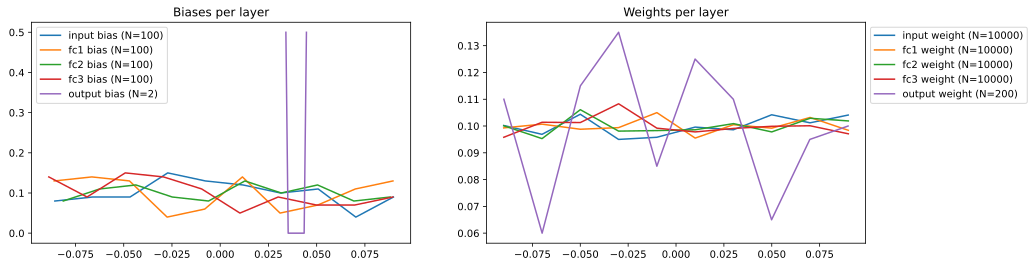

In [14]:
# Layer specific distribution

fig, ax = plt.subplots(1, 2, figsize=(15, 4))

for p in net.named_parameters():
    print(p[0])
    # get the data and compute their histogram
    thesedata = p[1].data.cpu().numpy().flatten()
    y, x = np.histogram(thesedata, 10)

    # for the bias
    if "bias" in p[0]:
        ax[0].plot(
            (x[1:] + x[:-1]) / 2,
            y / np.sum(y),
            label="%s bias (N=%g)" % (p[0][:-5], len(thesedata)),
        )

    # for the weights
    elif "weight" in p[0]:
        ax[1].plot(
            (x[1:] + x[:-1]) / 2,
            y / np.sum(y),
            label="%s weight (N=%g)" % (p[0][:-7], len(thesedata)),
        )


ax[0].set_title("Biases per layer")
ax[0].legend()
ax[1].set_title("Weights per layer")
ax[1].legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.show()

In [16]:
# Check documentation
nn.Linear?

Init signature:
nn.Linear(
    in_features: int,
    out_features: int,
    bias: bool = True,
    device=None,
    dtype=None,
) -> None
Docstring:     
Applies an affine linear transformation to the incoming data: :math:`y = xA^T + b`.

This module supports :ref:`TensorFloat32<tf32_on_ampere>`.

On certain ROCm devices, when using float16 inputs this module will use :ref:`different precision<fp16_on_mi200>` for backward.

Args:
    in_features: size of each input sample
    out_features: size of each output sample
    bias: If set to ``False``, the layer will not learn an additive bias.
        Default: ``True``

Shape:
    - Input: :math:`(*, H_{in})` where :math:`*` means any number of
      dimensions including none and :math:`H_{in} = \text{in\_features}`.
    - Output: :math:`(*, H_{out})` where all but the last dimension
      are the same shape as the input and :math:`H_{out} = \text{out\_features}`.

Attributes:
    weight: the learnable weights of the module of shape
       

In [ ]:
# Let's test whether the numbers match our prediction from the formula

# Empirical bias range
biasrange = [
    torch.min(net.fc1.bias.data).cpu().item(),
    torch.max(net.fc1.bias.data).cpu().item(),
]
biascount = len(net.fc1.bias.data)

# Theoretical expected value
sigma = np.sqrt(1 / biascount)

# Let's check the values
print(f"Theoretical sigma = {str(sigma)}")
print(f"Empirical range = {str(biasrange)}")

Theoretical sigma = 0.1
Empirical range = [-0.09579571336507797, 0.09930218756198883]


In [18]:
### Now to initialize the weights using the xavier method
# Create new model instance
net = thenet()

# Change the weights (leave biases as kaiming [default value])
for p in net.named_parameters():
    if 'weight' in p[0]:
        nn.init.xavier_normal_(p[1].data)